# JAX-CFD Immersed Body Demo

This demonstration shows how to use JAX-CFD to simulate 2d flow between parallel no-slip walls, with a no-slip immersed body in the center of the domain

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import numpy as np
import seaborn
import jax_cfd.base as cfd
import xarray


In [2]:
from jax_cfd.base.boundaries import channel_flow_with_simple_immersed_body_boundary_conditions

size = (512, 128)
domain = ((0, 8), (0, 2))
density = 1.
viscosity = 1e-3  # kinematic viscosity
pressure_gradient = 2e-3  # uniform dP/dx

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid(size, domain=domain)

# Use the new helper that returns a single ConstantBoundaryConditions
velocity_bc = (
    channel_flow_with_simple_immersed_body_boundary_conditions(grid, shape='circle', shape_size=0.25, bc_value=0.0),
    channel_flow_with_simple_immersed_body_boundary_conditions(grid, shape='circle', shape_size=0.25, bc_value=0.0),
)

# Specify zero velocity initial conditions
vx_fn = lambda x, y: jnp.zeros_like(x + y)
vy_fn = lambda x, y: jnp.zeros_like(x + y)

v0 = cfd.initial_conditions.initial_velocity_field(
    velocity_fns=(vx_fn, vy_fn),
    grid=grid,
    velocity_bc=velocity_bc,
    pressure_solve=cfd.pressure.solve_fast_diag_channel_flow,
    iterations=5
)

# Confirm that the divergence of v0 is zero
# div = cfd.finite_differences.divergence(v0)
# np.testing.assert_allclose(div.data, 0)

# Specify a fixed time step based on the convection and diffusion scales
max_velocity = 1  # value selected from known equilibrium profile
cfl_safety_factor = 0.5

dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid
)


In [3]:
# Define a linear force due to the uniform pressure gradient
def pressure_gradient_forcing(pressure_gradient: float):
  
  def forcing(v):
    force_vector = (pressure_gradient, 0)
    return tuple(cfd.grids.GridArray(f * jnp.ones_like(u.data), u.offset, u.grid)
                 for f, u in zip(force_vector, v))
  
  return forcing

In [ ]:
# time steps per output
inner_steps = 1_000

# number of outputs
outer_steps = 36

# TODO(pnorgaard): Fix Van-Leer limiters for Dirichlet velocity BC 
def convect(v):
  return tuple(
      cfd.advection.advect_van_leer(u, v, dt) for u in v)
  
# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve=cfd.pressure.solve_fast_diag_channel_flow,
        forcing=pressure_gradient_forcing(pressure_gradient),
        ),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(
    step_fn, outer_steps, start_with_input=True))

%time _, trajectory = jax.device_get(rollout_fn(v0))

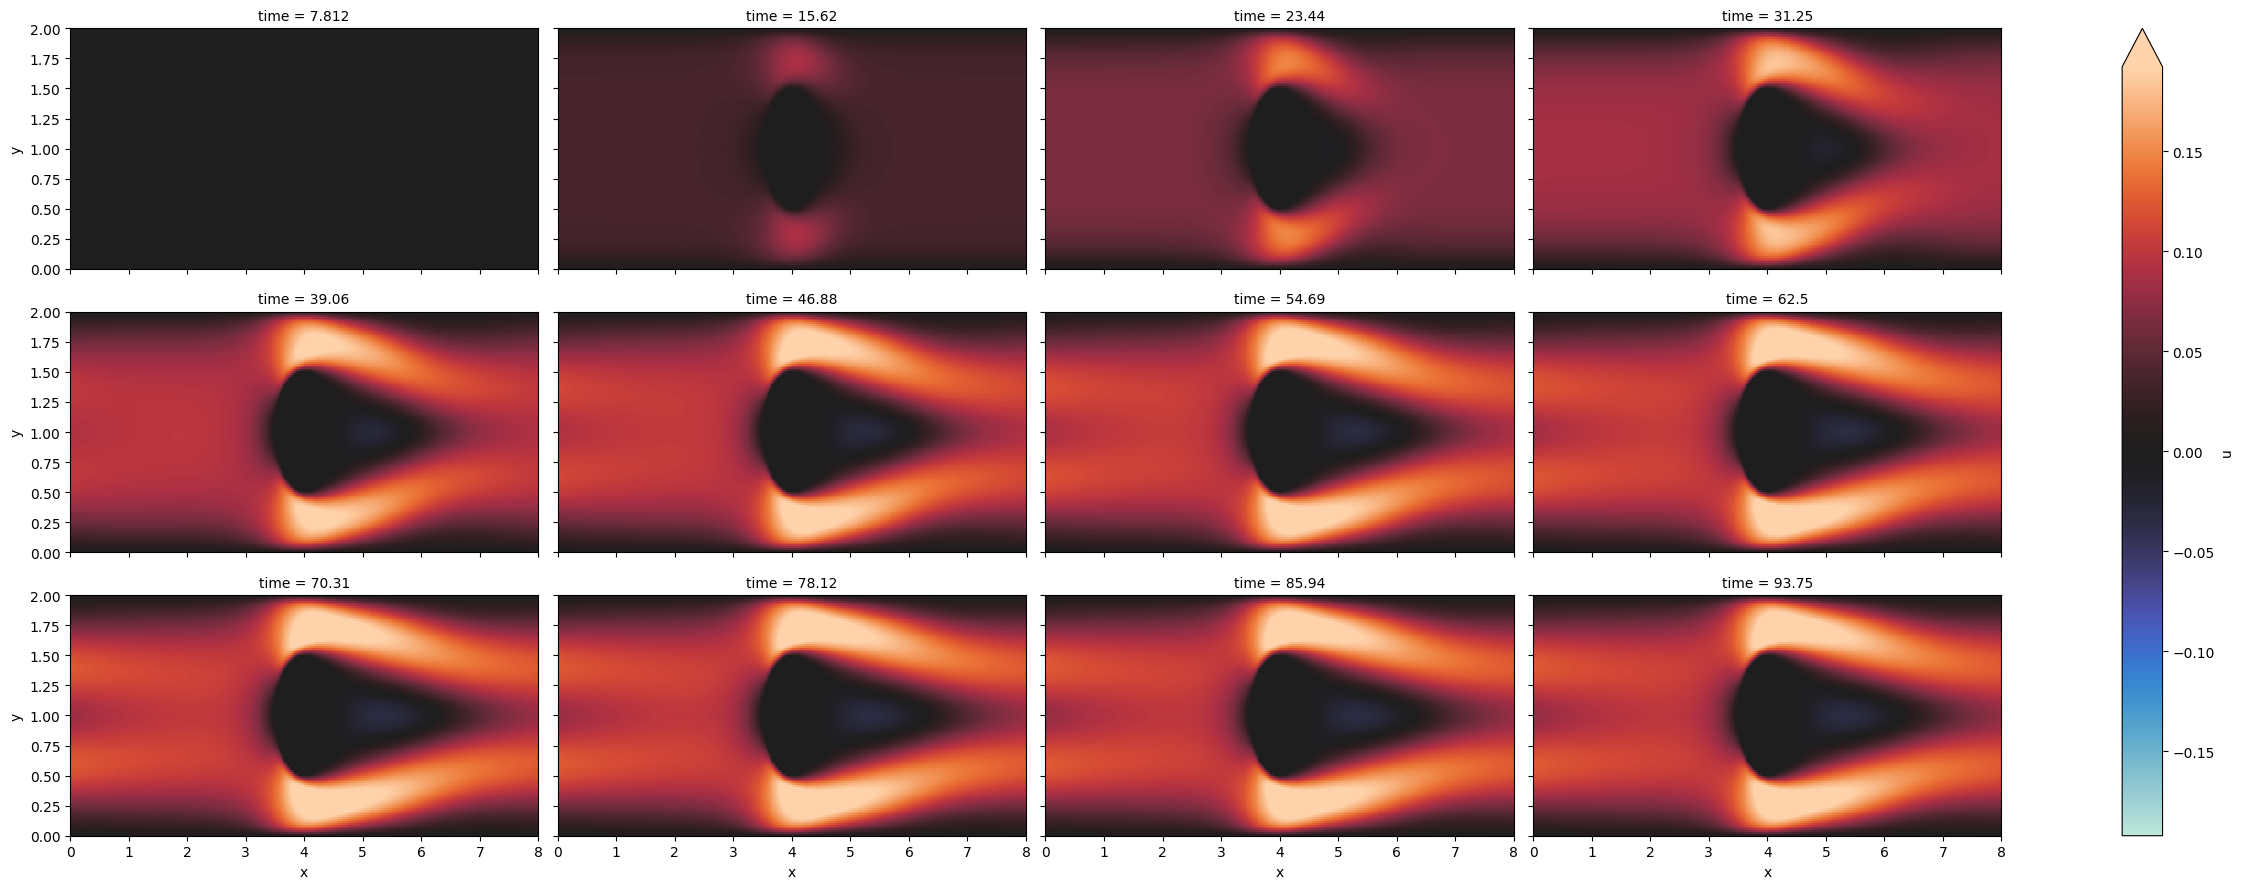

In [5]:
# load into xarray for visualization and analysis
gif_frames_to_plot_amount_ratio = 3
plotting_steps = outer_steps // gif_frames_to_plot_amount_ratio
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data[::gif_frames_to_plot_amount_ratio, :, :]),
        'v': (('time', 'x', 'y'), trajectory[1].data[::gif_frames_to_plot_amount_ratio, :, :]),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(1, plotting_steps + 1)
    } 
)

# Plot the x-velocity
ds.u.plot.imshow(
    x='x', y='y', col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=4, aspect=2);

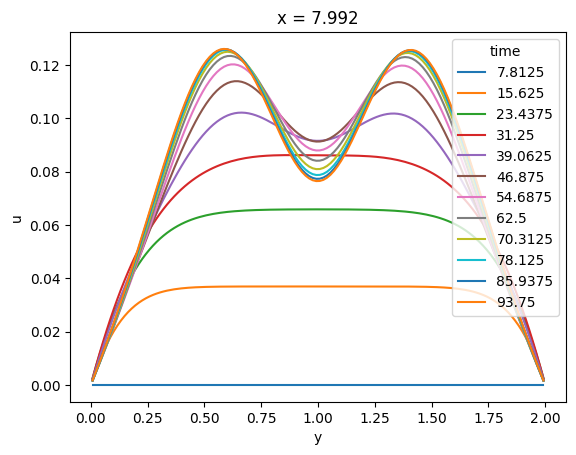

In [6]:
def vx_at_x_upper_boundary(ds):
  return ds.u.isel(x=-1)  # slice operator

p = ds.pipe(vx_at_x_upper_boundary).plot(hue='time')

In [7]:
from jax_cfd.data import visualization
trajectory = ds.u.values  # Convert xarray DataArray to numpy array
images = visualization.trajectory_to_images(trajectory, rotation_angle=90)
visualization.save_movie(images, 'output_flow_movie.gif', duration=150., loop=12)